 # Yolo v3 Object Detection in Tensorflow
 [GitHub repo link](https://github.com/heartkilla/yolo-v3) <br>
 UPDATE: Video processing
 <a id="top"></a> <br>
## Content
1. [What is Yolo?](#1)
2. [Dependencies](#2)
3. [Model hyperparameters](#3)
4. [Model definiton](#4)
5. [Utility functions](#5)
6. [Converting weights to Tensorflow format](#6)
7. [Running the model](#7)
8. [Video processing](#8)
9. [To-Do list](#9)
10. [Acknowledgements](#10)

<a id="1"></a> 
## 1. What is Yolo?
Yolo is an algorithm that uses convolutional neural networks for object detection. <br>
So what's great about object detection? In comparison to recognition algorithms, a detection algorithm does not only predict class labels, but detects locations of objects as well. 
![](https://i.ytimg.com/vi/yQwfDxBMtXg/maxresdefault.jpg)

<a id="2"></a> 
## 2. Dependencies
To build Yolo we're going to need Tensorflow (deep learning), NumPy (numerical computation) and Pillow (image processing) libraries. Also we're going to use seaborn's color palette for bounding boxes colors. Finally, let's import IPython function `display()` to display images in the notebook.

In [74]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont

from IPython.display import display
from seaborn import color_palette
import cv2

<a id="3"></a>
## 3. Model hyperparameters
Next, we define some configurations for Yolo. 

In [75]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)

`_MODEL_SIZE` refers to the input size of the model.

Let's look at other parameters step-by-step.

### Batch normalization
Almost every convolutional layer in Yolo has batch normalization after it. It helps the model train faster and reduces variance between units (and total variance as well). Batch normalization is defined as follows.
<br>
![](https://hsto.org/files/005/d19/2bd/005d192bd6274c298f75896498aea377.png)
<br>
`_BATCH_NORM_EPSILON` refers to epsilon in this formula, whereas `_BATCH_NORM_DECAY` refers to momentum, which is used for computing moving average and variance. We use them in forward propagation during inference (after training).
<br>
<br>
`moving_average = momentum * moving_average + (1 - momentum) * current_average`

### Leaky ReLU
Leaky ReLU is a slight modification of ReLU activation function. The idea behind Leaky ReLU is to prevent so-called "neuron dying" when a large number of activations become 0. 
<br>
![](https://i1.wp.com/sefiks.com/wp-content/uploads/2018/02/prelu.jpg?resize=300%2C201&ssl=1)
`_LEAKY_RELU` refers to alpha.

### Anchors
Anchors are sort of bounding box priors, that were calculated on the COCO dataset using k-means clustering. We are going to predict the width and height of the box as offsets from cluster centroids. The center coordinates of the box relative to the location of filter application are predicted using a sigmoid function.
<br>
$$b_{x} = \sigma(t_{x})+c_{x}$$
$$b_{y} = \sigma(t_{y})+c_{y}$$
$$b_{w} = p_{w}e^{t_{w}}$$
$$b_{h} = p_{h}e^{t_{h}}$$
<br>
Where $b_{x}$ and $b_{y}$ are the center coordinates of the box, $b_{w}$ and $b_{h}$ are the width and height of the box, $c_{x}$ and $c_{y}$ are the location of filter application and $t_{i}$ are predicted during regression.

<a id="4"></a>
## 4. Model definition
I refered to the official ResNet implementation in Tensorflow in terms of how to arange the code. 

### Batch norm and fixed padding
It's useful to define `batch_norm` function since the model uses batch norms with shared parameters heavily. Also, same as ResNet, Yolo uses convolution with fixed padding, which means that padding is defined only by the size of the kernel.

In [76]:
def batch_norm(inputs, training, data_format):
    """Performs a batch normalization using a standard set of parameters."""
    return tf.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)


def fixed_padding(inputs, kernel_size, data_format):
    """ResNet implementation of fixed padding.

    Pads the input along the spatial dimensions independently of input size.

    Args:
        inputs: Tensor input to be padded.
        kernel_size: The kernel to be used in the conv2d or max_pool2d.
        data_format: The input format.
    Returns:
        A tensor with the same format as the input.
    """
    pad_total = kernel_size - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg

    if data_format == 'channels_first':
        padded_inputs = tf.pad(inputs, [[0, 0], [0, 0],
                                        [pad_beg, pad_end],
                                        [pad_beg, pad_end]])
    else:
        padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]])
    return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, data_format, strides=1):
    """Strided 2-D convolution with explicit padding."""
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size, data_format)

    return tf.layers.conv2d(
        inputs=inputs, filters=filters, kernel_size=kernel_size,
        strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
        use_bias=False, data_format=data_format)

### Feature extraction: Darknet-53
For feature extraction Yolo uses Darknet-53 neural net pretrained on ImageNet. Same as ResNet,  Darknet-53 has shortcut (residual) connections, which help information from earlier layers flow further. We omit the last 3 layers (Avgpool, Connected and Softmax) since we only need the features.

In [77]:
def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
    """Creates a residual block for Darknet."""
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs


def darknet53(inputs, training, data_format):
    """Creates Darknet53 model for feature extraction."""
    inputs = conv2d_fixed_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv2d_fixed_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs

### Convolution layers
Yolo has a large number of convolutional layers. It's useful to group them in blocks.

In [78]:
def yolo_convolution_block(inputs, filters, training, data_format):
    """Creates convolution operations layer used after Darknet."""
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    route = inputs

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return route, inputs

### Detection layers
Yolo has 3 detection layers, that detect on 3 different scales using respective anchors. For each cell in the feature map the detection layer predicts `n_anchors * (5 + n_classes)` values using 1x1 convolution. For each scale we have `n_anchors = 3`. `5 + n_classes` means that respectively to each of 3 anchors we are going to predict 4 coordinates of the box, its confidence score (the probability of containing an object) and class probabilities. 

In [79]:
def yolo_layer(inputs, n_classes, anchors, img_size, data_format):
    """Creates Yolo final detection layer.

    Detects boxes with respect to anchors.

    Args:
        inputs: Tensor input.
        n_classes: Number of labels.
        anchors: A list of anchor sizes.
        img_size: The input size of the model.
        data_format: The input format.

    Returns:
        Tensor output.
    """
    n_anchors = len(anchors)

    inputs = tf.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)

    shape = inputs.get_shape().as_list()
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])

    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides

    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchors)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)

    return inputs

### Upsample layer
In order to concatenate with shortcut outputs from Darknet-53 before applying detection on a different scale, we are going to upsample the feature map using nearest neighbor interpolation.

In [80]:
def upsample(inputs, out_shape, data_format):
    """Upsamples to `out_shape` using nearest neighbor interpolation."""
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        new_height = out_shape[3]
        new_width = out_shape[2]
    else:
        new_height = out_shape[2]
        new_width = out_shape[1]

    inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs

### Non-max suppression
The model is going to produce a lot of boxes, so we need a way to discard the boxes with low confidence scores. Also, to avoid having multiple boxes for one object, we will discard the boxes with high overlap as well using non-max suppresion for each class.

In [81]:
def build_boxes(inputs):
    """Computes top left and bottom right points of the boxes."""
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes


def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
    """Performs non-max suppression separately for each class.

    Args:
        inputs: Tensor input.
        n_classes: Number of classes.
        max_output_size: Max number of boxes to be selected for each class.
        iou_threshold: Threshold for the IOU.
        confidence_threshold: Threshold for the confidence score.
    Returns:
        A list containing class-to-boxes dictionaries
            for each sample in the batch.
    """
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts

### Final model class
Finally, let's define the model class using all of the layers described previously. 

In [82]:
class Yolo_v3:
    """Yolo v3 model class."""

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
        """Creates the model.

        Args:
            n_classes: Number of class labels.
            model_size: The input size of the model.
            max_output_size: Max number of boxes to be selected for each class.
            iou_threshold: Threshold for the IOU.
            confidence_threshold: Threshold for the confidence score.
            data_format: The input format.

        Returns:
            None.
        """
        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'

        self.n_classes = n_classes
        self.model_size = model_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):
        """Add operations to detect boxes for a batch of input images.

        Args:
            inputs: A Tensor representing a batch of input images.
            training: A boolean, whether to use in training or inference mode.

        Returns:
            A list containing class-to-boxes dictionaries
                for each sample in the batch.
        """
        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255

            route1, route2, inputs = darknet53(inputs, training=training,
                                               data_format=self.data_format)

            route, inputs = yolo_convolution_block(
                inputs, filters=512, training=training,
                data_format=self.data_format)
            detect1 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[6:9],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=256, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route2.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            axis = 1 if self.data_format == 'channels_first' else 3
            inputs = tf.concat([inputs, route2], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=256, training=training,
                data_format=self.data_format)
            detect2 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[3:6],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=128, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route1.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            inputs = tf.concat([inputs, route1], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=128, training=training,
                data_format=self.data_format)
            detect3 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[0:3],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

<a id="5"></a>
## 5. Utility functions
Here are some utility functions that will help us load images as NumPy arrays, load class names from the official file and draw the predicted boxes.

In [95]:
def load_images(img_names, model_size):
    """Loads images in a 4D array.

    Args:
        img_names: A list of images names.
        model_size: The input size of the model.
        data_format: A format for the array returned
            ('channels_first' or 'channels_last').

    Returns:
        A 4D NumPy array.
    """
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):
    """Returns a list of class names read from `file_name`."""
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size):
    """Draws detected boxes.

    Args:
        img_names: A list of input images names.
        boxes_dict: A class-to-boxes dictionary.
        class_names: A class names list.
        model_size: The input size of the model.

    Returns:
        None.
    """
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        # font = ImageFont.truetype(font='../input/futur.ttf',
        #                           size=(img.size[0] + img.size[1]) // 100)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 200
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    text = '{} {:.1f}%'.format(class_names[cls],
                                               confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle(
                        [x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)

        display(img)

<a id="6"></a>
## 6. Converting weights to Tensorflow format
Now it's time to load the official weights. We are going to iterate through the file and gradually create `tf.assign` operations.

In [84]:
def load_weights(variables, file_name):
    """Reshapes and loads official pretrained Yolo weights.

    Args:
        variables: A list of tf.Variable to be assigned.
        file_name: A name of a file containing weights.

    Returns:
        A list of assign operations.
    """
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

    return assign_ops

<a id="7"></a>
## 7. Running the model
Now we can run the model using some sample images.

### Sample images

In [125]:
# img_names = ['dog.jpg', 'office.jpg']
img_names = ['s3.jpg']
# for img in img_names: display(Image.open(img))

### Detections
Testing the model with IoU (Interception over Union ratio used in non-max suppression) threshold and confidence threshold both set to 0.5.

In [86]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [126]:
tf.reset_default_graph()

In [127]:
batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold,data_format = 'channels_last')

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars, 'yolov3.weights')

with tf.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.


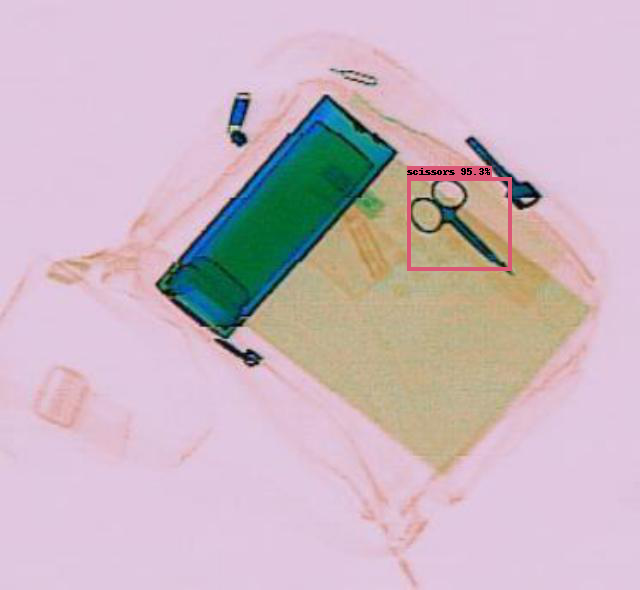

In [128]:
draw_boxes(img_names, detection_result, class_names, _MODEL_SIZE)

<a id="8"></a>
## 8. Video processing
I also applied the same algorithm to video detections. The code is available on my [GitHub repo](https://github.com/heartkilla/yolo-v3). <br>
Here is an example of applying Yolo to a video I found on YouTube. ([A Street Walk in Shinjuku, Tokyo, Japan](https://www.youtube.com/watch?v=kZ7caIK4RXI))
![](https://github.com/heartkilla/yolo-v3/blob/master/data/detection_examples/detections.gif)

<a id="10"></a>
## 10. Acknowledgements
* [Yolo v3 official paper](https://arxiv.org/abs/1804.02767)
* [A Tensorflow Slim implementation](https://github.com/mystic123/tensorflow-yolo-v3)
* [ResNet official implementation](https://github.com/tensorflow/models/tree/master/official/resnet)
* [DeviceHive video analysis repo](https://github.com/devicehive/devicehive-video-analysis)
* [A Street Walk in Shinjuku, Tokyo, Japan](https://www.youtube.com/watch?v=kZ7caIK4RXI)

Special thanks to [Paul]( https://www.kaggle.com/paultimothymooney) for posting this kernel in [Kaggle Data Notes Newsletter](https://www.kaggle.com/page/data-notes).
